# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
#Подгружаем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import lightgbm as lgm
import copy
import time
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Подгружаем датасет
data = pd.read_csv('/datasets/autos.csv')
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
# избавимся от ненужных колонок и выделим категориальные
data.columns = ['DateCrawled', 'Price', 'VehicleType_cat', 'RegistrationYear', 'Gearbox_cat',
       'Power', 'Model_cat', 'Kilometer', 'RegistrationMonth', 'FuelType_cat', 'Brand_cat',
       'Repaired_cat', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen']

data = data.drop(['DateCrawled','DateCreated','LastSeen','NumberOfPictures', 'PostalCode'], axis=1)

category_columns = ['VehicleType_cat', 'Gearbox_cat', 'Model_cat', 'FuelType_cat',
           'Brand_cat', 'RegistrationMonth_cat', 'Repaired_cat']

In [6]:
data.duplicated().sum()

27543

In [7]:
#Удаляем пропуски
data.drop_duplicates(inplace=True)

In [8]:
#Изучаем пропуски
nan = data.isna().sum()
nan

Price                    0
VehicleType_cat      35249
RegistrationYear         0
Gearbox_cat          17578
Power                    0
Model_cat            18532
Kilometer                0
RegistrationMonth        0
FuelType_cat         31122
Brand_cat                0
Repaired_cat         66427
dtype: int64

In [9]:
perc_nan = nan / data.shape[0]
perc_nan.sort_values(ascending=False)

Repaired_cat         0.203249
VehicleType_cat      0.107852
FuelType_cat         0.095225
Model_cat            0.056703
Gearbox_cat          0.053784
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand_cat            0.000000
dtype: float64

<AxesSubplot:ylabel='Density'>

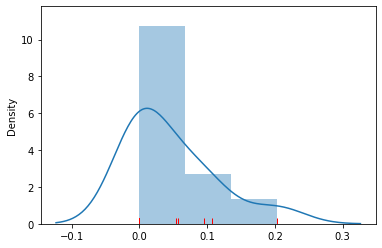

In [10]:
sns.distplot(perc_nan, rug=True, rug_kws={"color": "r"})

In [11]:
#data.dropna(subset=['VehicleType_cat', 'Gearbox_cat', 'Model_cat', 'FuelType_cat', 'Repaired_cat'], inplace=True)

In [12]:
data['VehicleType_cat'] = data['VehicleType_cat'].fillna('unk')
data['Gearbox_cat'] = data['Gearbox_cat'].fillna('unk')
data['Model_cat'] = data['Model_cat'].fillna('unk')
data['FuelType_cat'] = data['FuelType_cat'].fillna('unk')
data['Repaired_cat'] = data['Repaired_cat'].fillna('unk')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326826 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              326826 non-null  int64 
 1   VehicleType_cat    326826 non-null  object
 2   RegistrationYear   326826 non-null  int64 
 3   Gearbox_cat        326826 non-null  object
 4   Power              326826 non-null  int64 
 5   Model_cat          326826 non-null  object
 6   Kilometer          326826 non-null  int64 
 7   RegistrationMonth  326826 non-null  int64 
 8   FuelType_cat       326826 non-null  object
 9   Brand_cat          326826 non-null  object
 10  Repaired_cat       326826 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.9+ MB


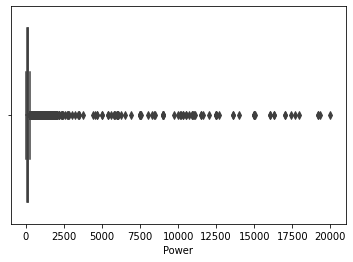

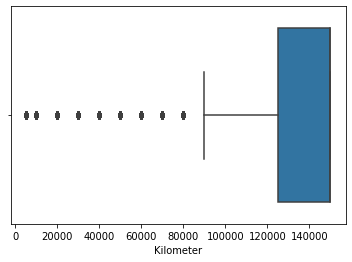

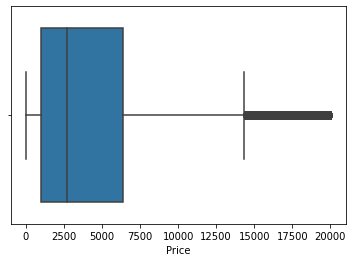

In [13]:
#Изучаем аномалии
for a in ['Power','Kilometer','Price']:
    sns.boxplot(data[a]) 
    plt.show()

Видим явные аномалии в цене, надо сделать по ним срез. И много нулевых значений с цене и мощности, их можно заменить средним значением. Сделаем сводные таблицы и в них заменим на средние, а затем применим их к основному датасету

In [14]:
data = data.query('Price < 14000')
data = data.query('Price != 1')
power_new = data.pivot_table(columns='Model_cat', values='Power', aggfunc='mean').astype('int').to_dict()
price_new = data.pivot_table(columns='Model_cat', values='Price', aggfunc='mean').astype('int').to_dict()

def fill_0(row, cat, place, table):
    a = row[cat]
    b = table[a][place]
    if row[place] == 0:  
        row[place] = b
    return row
        
data = data.apply(fill_0, axis=1, args=('Model_cat','Power', power_new))
data = data.apply(fill_0, axis=1, args=('Model_cat','Price', price_new))

data.head(10)

,Price,VehicleType_cat,RegistrationYear,Gearbox_cat,Power,Model_cat,Kilometer,RegistrationMonth,FuelType_cat,Brand_cat,Repaired_cat
0,480,unk,1993,manual,95,golf,150000,0,petrol,volkswagen,unk
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unk
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
7,3554,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
9,999,small,1998,manual,101,golf,150000,0,unk,volkswagen,unk
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes


In [15]:
# Отрежем цены ниже 100 евро и уберем нулевые значения мощностей
data = data.query('Power != 0')
data = data.query('Price > 100')
data = data.query('RegistrationYear >= 2016')

Данные готовы к построению модели

## Обучение моделей

In [16]:
# Создадим функцию для оценки времени и качества моделей
def time_score(model, features_train, target_train, features_test, target_test):
    
    start = time.time()    
    model.fit(features_train, target_train)
    train_time = time.time() - start
    
    start = time.time()  
    predict = model.predict(features_test)
    predict_time = time.time() - start

    return train_time, predict_time, mean_squared_error(target_test, predict)**0.5

In [17]:
# Разделим датасет
features = data.drop(['Price'], axis = 1)  
target = data['Price'] 

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

print('Размер тренировочной выборки:', features_train.shape) 
print('Размер тестовой выборки:', features_test.shape) 
print('Размер валидационной выборки:', features_valid.shape) 

Размер тренировочной выборки: (13393, 10)
Размер тестовой выборки: (4465, 10)
Размер валидационной выборки: (4465, 10)


In [18]:
# Предаем категориальное значения столбцам
features_train['VehicleType_cat'] = features_train['VehicleType_cat'].astype('category')
features_train['Gearbox_cat'] = features_train['Gearbox_cat'].astype('category')
features_train['Model_cat'] = features_train['Model_cat'].astype('category')
features_train['FuelType_cat'] = features_train['FuelType_cat'].astype('category')
features_train['Brand_cat'] = features_train['Brand_cat'].astype('category')
features_train['Repaired_cat'] = features_train['Repaired_cat'].astype('category')

features_valid['VehicleType_cat'] = features_valid['VehicleType_cat'].astype('category')
features_valid['Gearbox_cat'] = features_valid['Gearbox_cat'].astype('category')
features_valid['Model_cat'] = features_valid['Model_cat'].astype('category')
features_valid['FuelType_cat'] = features_valid['FuelType_cat'].astype('category')
features_valid['Brand_cat'] = features_valid['Brand_cat'].astype('category')
features_valid['Repaired_cat'] = features_valid['Repaired_cat'].astype('category')

features_test['VehicleType_cat'] = features_test['VehicleType_cat'].astype('category')
features_test['Gearbox_cat'] = features_test['Gearbox_cat'].astype('category')
features_test['Model_cat'] = features_test['Model_cat'].astype('category')
features_test['FuelType_cat'] = features_test['FuelType_cat'].astype('category')
features_test['Brand_cat'] = features_test['Brand_cat'].astype('category')
features_test['Repaired_cat'] = features_test['Repaired_cat'].astype('category')
category_features = [c for c, col in enumerate(features_train.columns) if '_cat' in col]

In [19]:

estim = lgb.LGBMRegressor()
estim.fit(features_train, target_train, eval_metric='rmse', categorical_feature=category_features)
predicted_valid = estim.predict(features_valid)
predicted_train = estim.predict(features_train)
print('The rmse of LGBMRegressor prediction on train:', mean_squared_error(target_train, predicted_train) ** 0.5)
print('The rmse of LGBMRegressor prediction on valid:', mean_squared_error(target_valid, predicted_valid) ** 0.5)

The rmse of LGBMRegressor prediction on train: 1495.6019912307927
The rmse of LGBMRegressor prediction on valid: 1696.2116151164653


In [20]:
#Подбираем параметры 



#estim_new = lgb.LGBMRegressor(num_leaves= 31,learning_rate=0.01)

#param_grid = {
#    'n_estimators': [10,50,100,200,250],
#    'max_depth': [1,5,10,15,20]
#   
#}

#cv =KFold(shuffle=True, n_splits=7)
#gbm = GridSearchCV(estim_new, param_grid, cv=cv, scoring='neg_mean_squared_error')

#gbm.fit(features_train, target_train, categorical_feature=category_features)

#print('Best parameters is:', gbm.best_params_)
#print('Best score is:', gbm.best_score_)

Лучшие параметры для модели это max_depth: 10, n_estimators: 250

In [21]:
#Применим параметры на модели

model = lgb.LGBMRegressor(num_leaves= 31, learning_rate=0.01, max_depth=10, n_estimators=250)
model.fit(features_train, target_train, categorical_feature=category_features)
predicted_valid1 = model.predict(features_valid)
rmse = (mean_squared_error(target_valid, predicted_valid1))**0.5

rmse

1771.5608441821628

In [22]:
# Применим функцию для оценки качества и времени модели
result = []
result.append(time_score(model, features_train, target_train, features_valid, target_valid))

In [23]:
# Обучим CatBoost

model_cat = CatBoostRegressor(n_estimators = 200, loss_function = 'MAE', eval_metric = 'RMSE', cat_features = category_features)
model_cat.fit(features_train, target_train, cat_features=category_features, verbose=10)
predicted_valid2 = model_cat.predict(features_valid)
rmse = (mean_squared_error(target_valid, predicted_valid2))**0.5
rmse

0:	learn: 2784.2274004	total: 67ms	remaining: 13.3s
10:	learn: 2576.3126854	total: 244ms	remaining: 4.18s
20:	learn: 2433.7146675	total: 412ms	remaining: 3.51s
30:	learn: 2329.3577235	total: 579ms	remaining: 3.16s
40:	learn: 2252.8607214	total: 763ms	remaining: 2.96s
50:	learn: 2197.9085142	total: 924ms	remaining: 2.7s
60:	learn: 2158.3455393	total: 1.08s	remaining: 2.46s
70:	learn: 2125.5655418	total: 1.25s	remaining: 2.28s
80:	learn: 2092.9010622	total: 1.44s	remaining: 2.12s
90:	learn: 2066.6820366	total: 1.63s	remaining: 1.95s
100:	learn: 2047.2061605	total: 1.8s	remaining: 1.76s
110:	learn: 2030.1947017	total: 1.97s	remaining: 1.58s
120:	learn: 2009.6251015	total: 2.14s	remaining: 1.4s
130:	learn: 1991.4510089	total: 2.32s	remaining: 1.22s
140:	learn: 1983.0601683	total: 2.49s	remaining: 1.04s
150:	learn: 1971.5253133	total: 2.65s	remaining: 859ms
160:	learn: 1961.5297894	total: 2.81s	remaining: 682ms
170:	learn: 1954.3917999	total: 2.98s	remaining: 505ms
180:	learn: 1946.8408433	

1876.1754552947484

In [29]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['Repaired_cat', 'Brand_cat', 'FuelType_cat', 'Model_cat', 'Gearbox_cat', 'VehicleType_cat']
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

In [30]:
n_estimators = list(range(40, 121, 40))
max_depth = list(range(10, 41, 10))

hyperparams_rfr = {'n_estimators':n_estimators,
                'max_depth':max_depth,
                'random_state':[555]}

In [32]:
%%time

model_ord = GridSearchCV(estimator = RandomForestRegressor(), 
                        param_grid = hyperparams_rfr, 
                        scoring='neg_mean_squared_error',
                        cv=3,
                        n_jobs = -1)
model_ord.fit(features_train_ord, target_train)

CPU times: user 1min, sys: 140 ms, total: 1min
Wall time: 1min


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40],
                         'n_estimators': [40, 80, 120], 'random_state': [555]},
             scoring='neg_mean_squared_error')

In [37]:
time_score(model_ord, features_train_ord, target_train, features_valid_ord, target_valid)

(60.69884204864502, 0.058591365814208984, 1852.6785339655787)

In [38]:
# Применим функцию для оценки качества и времени модели
result.append(time_score(model_ord, features_train_ord, target_train, features_valid_ord, target_valid))

Модель случайного леса выдает хороший результат RMSE, но очень большое время. 

## Анализ моделей

In [39]:
# Применим функцию для оценки качества и времени модели
result.append(time_score(model_cat, features_train, target_train, features_valid, target_valid))

0:	learn: 2784.2274004	total: 20.3ms	remaining: 4.04s
1:	learn: 2758.5638585	total: 36.3ms	remaining: 3.59s
2:	learn: 2735.8261826	total: 58.1ms	remaining: 3.81s
3:	learn: 2713.1123286	total: 76.8ms	remaining: 3.76s
4:	learn: 2690.3609233	total: 95.3ms	remaining: 3.72s
5:	learn: 2667.8703406	total: 115ms	remaining: 3.71s
6:	learn: 2648.5679482	total: 133ms	remaining: 3.67s
7:	learn: 2630.0787568	total: 149ms	remaining: 3.57s
8:	learn: 2612.3267752	total: 167ms	remaining: 3.55s
9:	learn: 2594.4461704	total: 185ms	remaining: 3.52s
10:	learn: 2576.3126854	total: 200ms	remaining: 3.44s
11:	learn: 2563.2427244	total: 217ms	remaining: 3.39s
12:	learn: 2546.0946942	total: 237ms	remaining: 3.41s
13:	learn: 2527.2089048	total: 255ms	remaining: 3.39s
14:	learn: 2509.8448164	total: 276ms	remaining: 3.4s
15:	learn: 2495.4247903	total: 291ms	remaining: 3.34s
16:	learn: 2482.4666208	total: 306ms	remaining: 3.3s
17:	learn: 2472.9868362	total: 325ms	remaining: 3.28s
18:	learn: 2459.0046060	total: 341m

In [42]:
pd.DataFrame(data=result,
index=['LightGBM', 'Ord', 'CatBoost'],
columns=['Время_обучения', 'Время_Предсказания', 'RMSE'])

,Время_обучения,Время_Предсказания,RMSE
LightGBM,3.199728,0.197480,1771.560844
Ord,61.184577,0.068679,1852.678534
CatBoost,4.451061,0.010448,1876.175455


## Тестирование лучшей модели

In [43]:
final_test = time_score(model_cat, features_train, target_train, features_test, target_test)

0:	learn: 2784.2274004	total: 21.6ms	remaining: 4.29s
1:	learn: 2758.5638585	total: 37.3ms	remaining: 3.7s
2:	learn: 2735.8261826	total: 58.6ms	remaining: 3.85s
3:	learn: 2713.1123286	total: 88ms	remaining: 4.31s
4:	learn: 2690.3609233	total: 114ms	remaining: 4.46s
5:	learn: 2667.8703406	total: 141ms	remaining: 4.56s
6:	learn: 2648.5679482	total: 171ms	remaining: 4.72s
7:	learn: 2630.0787568	total: 187ms	remaining: 4.49s
8:	learn: 2612.3267752	total: 211ms	remaining: 4.48s
9:	learn: 2594.4461704	total: 243ms	remaining: 4.62s
10:	learn: 2576.3126854	total: 266ms	remaining: 4.57s
11:	learn: 2563.2427244	total: 287ms	remaining: 4.49s
12:	learn: 2546.0946942	total: 311ms	remaining: 4.47s
13:	learn: 2527.2089048	total: 341ms	remaining: 4.53s
14:	learn: 2509.8448164	total: 371ms	remaining: 4.57s
15:	learn: 2495.4247903	total: 396ms	remaining: 4.56s
16:	learn: 2482.4666208	total: 423ms	remaining: 4.56s
17:	learn: 2472.9868362	total: 455ms	remaining: 4.6s
18:	learn: 2459.0046060	total: 479ms	r

In [44]:
final_test

(4.816826820373535, 0.009735107421875, 1940.9263836122939)

Вывод: После ознакомления с датасетом были выявленны дубликаты, которые я удалил. Также были удаленны пропуски. После чего я выявил аномалии в цене и сделал по ним срез. Нулевые значения в цене и мощности я заменил средним значением. После чего я приступил к обучению модели. Сначало я создал функцию для оценки качества и времени обучения моделей. Далее я разделил выборку на обучающую и валидационную и передал категориальные значения некоторым столбцам. Далее я приступил к анализу данных. Я начал подбирать лучшие параметры ими стали max_depth: 10, n_estimators: 250. После чего я применил эти параметры на модели и применил функцию для оценки качества. После сравнения двух моделей CatBoost и LightGBM, было выявленно что LightGBM лучшая модель т.к. скорость обучения у нее лучше.

Вывод 2:

Критерии, которые важны заказчику:
качество предсказания;
время обучения модели;
время предсказания модели. 
Согласно этим критериям я могу посоветовать модель CatBoost, у нее самое быстрое обучение модели и лучшие показатели RMSE